# TensorFlow를 이용한 딥러닝

기존의 머신러닝은 통계 방법을 사용하여 특징(feature)과 라벨(label) 사이의 관계를 결정하는 데에 의존하면서 예측 모델을 만드는 데 매우 효과적일 수 있습니다. 하지만 엄청난 데이터 가용성의 증가는 그것을 처리하는 데 필요한 컴퓨팅 기술의 발전과 결합되어 인간의 뇌가 인공 신경망이라고 불리는 구조에서 정보를 처리하는 방식을 모방하여 새로운 머신러닝 기술의 출현으로 이어졌습니다.

TensorFlow는 깊은 신경망(deep neural networks, DNN)을 포함한 머신러닝 모델을 만들기 위한 프레임워크입니다. 이 예에서는 TensorFlow를 사용하여 부리(culmen)의 길이와 깊이, 날개(FlipperLength) 및 체질량(BodyMass)을 기준으로 펭귄의 종으로 분류하는 간단한 신경망을 생성합니다.

> **인용**: 이 연습에 사용된 펭귄 데이터셋은 [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) 과 [Long Term Ecological Research Network](https://lternet.edu/)의 멤버인 [Palmer Station, Antarctica LTER](https://pal.lternet.edu/)이 수집하여 사용할 수 있게 만든 데이터의 서브셋이다.

## 데이터셋 살펴보기

PyTorch를 사용하기 전에 모델을 만들기 위해 Palmer Islands 펭귄 데이터셋으로부터 필요한 데이터를 불러오겠습니다. 이 데이터셋에는 3가지 종류의 펭귄이 관찰되어 있습니다.

> **참조**: 실제로는 딥러닝 모델 없이도 기존의 머신러닝 기술을 사용하여 펭귄 분류 문제를 쉽게 해결할 수 있습니다. 하지만 이 노트북에서 신경 네트워크의 원리를 설명하는 데이터셋은 유용하고 이해하기 쉽습니다.

In [1]:
import pandas as pd

# load the training dataset (excluding rows with null values)
penguins = pd.read_csv('data/penguins.csv').dropna()

# Deep Learning models work best when features are on similar scales
# In a real solution, we'd implement some custom normalization for each feature, but to keep things simple
# we'll just rescale the FlipperLength and BodyMass so they're on a similar scale to the bill measurements
penguins['FlipperLength'] = penguins['FlipperLength']/10
penguins['BodyMass'] = penguins['BodyMass']/100

# The dataset is too small to be useful for deep learning
# So we'll oversample it to increase its size
for i in range(1,3):
    penguins = penguins.append(penguins)

# Display a random sample of 10 observations
sample = penguins.sample(10)
sample

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
148,36.0,17.8,19.5,34.50,0
153,50.0,16.3,23.0,57.00,1
232,49.1,14.5,21.2,46.25,1
288,47.0,17.3,18.5,37.00,2
340,43.5,18.1,20.2,34.00,2
302,50.5,18.4,20.0,34.00,2
285,51.3,19.9,19.8,37.00,2
278,51.3,19.2,19.3,36.50,2
182,47.3,15.3,22.2,52.50,1
47,37.5,18.9,17.9,29.75,0


**Species** 열은 모델이 예측할 레이블입니다. 각 라벨 값은 0, 1 또는 2로 인코딩된 펭귄 종의 클래스를 나타냅니다. 다음 코드는 이러한 클래스 라벨에 해당하는 실제 종을 보여줍니다.

In [2]:
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    print('[',row[0], row[1], row[2],row[3], int(row[4]), ']',penguin_classes[int(row[-1])])

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 50.2 18.8 20.2 38.0 2 ] Chinstrap
[ 36.3 19.5 19.0 38.0 0 ] Adelie
[ 50.7 15.0 22.3 55.5 1 ] Gentoo
[ 36.0 17.8 19.5 34.5 0 ] Adelie
[ 45.3 13.8 20.8 42.0 1 ] Gentoo
[ 48.7 14.1 21.0 44.5 1 ] Gentoo
[ 40.5 17.9 18.7 32.0 0 ] Adelie
[ 37.7 16.0 18.3 30.75 0 ] Adelie
[ 42.5 20.7 19.7 45.0 0 ] Adelie
[ 36.8 18.5 19.3 35.0 0 ] Adelie


흔히 지도학습 문제에서 볼 수 있듯이, 데이터셋을 일련의 레코드로 분할하여 모델을 학습하고, 학습된 모델을 검증할 수 있는 작은 데이터셋으로 분할합니다.

In [3]:
from sklearn.model_selection import train_test_split

features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
label = 'Species'
   
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(penguins[features].values,
                                                    penguins[label].values,
                                                    test_size=0.30,
                                                    random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
print("Sample of features and labels:")

# Take a look at the first 25 training features and corresponding labels
for n in range(0,24):
    print(x_train[n], y_train[n], '(' + penguin_classes[y_train[n]] + ')')

Training Set: 957, Test Set: 411 

Sample of features and labels:
[51.1 16.5 22.5 52.5] 1 (Gentoo)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.5 16.2 22.9 58. ] 1 (Gentoo)
[39.3 20.6 19.  36.5] 0 (Adelie)
[42.5 20.7 19.7 45. ] 0 (Adelie)
[50.  15.3 22.  55.5] 1 (Gentoo)
[50.2  18.7  19.8  37.75] 2 (Chinstrap)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.1  14.5  21.2  46.25] 1 (Gentoo)
[43.2 16.6 18.7 29. ] 2 (Chinstrap)
[38.8  17.6  19.1  32.75] 0 (Adelie)
[37.8 17.1 18.6 33. ] 0 (Adelie)
[45.8 14.2 21.9 47. ] 1 (Gentoo)
[43.8 13.9 20.8 43. ] 1 (Gentoo)
[36.  17.1 18.7 37. ] 0 (Adelie)
[43.3 13.4 20.9 44. ] 1 (Gentoo)
[36.  18.5 18.6 31. ] 0 (Adelie)
[41.1  19.   18.2  34.25] 0 (Adelie)
[33.1 16.1 17.8 29. ] 0 (Adelie)
[40.9 13.7 21.4 46.5] 1 (Gentoo)
[45.2 17.8 19.8 39.5] 2 (Chinstrap)
[48.4 14.6 21.3 58.5] 1 (Gentoo)
[43.6 13.9 21.7 49. ] 1 (Gentoo)
[38.5  17.9  19.   33.25] 0 (Adelie)


*특징(features)*은 각 펭귄 관찰에 대한 측정치이며 *라벨(label)* 은 관찰이 나타내는 펭귄의 종(Adelie, Gentoo 또는 Chinstrap)을 나타내는 숫자 값입니다.

## TensorFlow 라이브러리 설치 및 임포트

TensorFlow를 사용하여 펭귄 분류 모델을 만들 예정이기 때문에, 사용하려는 라이브러리를 설치하고 임포트 하기 위해 아래 2개의 셀을 실행해야 합니다.

> **참조** *Keras* 는 기본 TensorFlow API를 통한 abstraction layer입니다. 대부분의 일반적인 시스템 학습 시나리오에서 Keras를 사용하여 코드를 단순화할 수 있습니다.

In [ ]:
# !pip install --upgrade tensorflow

In [4]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras import optimizers

# Set random seed for reproducability
tensorflow.random.set_seed(0)

print("Libraries imported.")
print('Keras version:',keras.__version__)
print('TensorFlow version:',tensorflow.__version__)

Libraries imported.
Keras version: 2.4.0
TensorFlow version: 2.4.1


## TensorFlow에서 데이터 준비하기

우리는 이미 데이터를 로드하여 학습 및 검증 데이터셋으로 분할했습니다.그러나 데이터가 TensorFlow에서 올바르게 작동하도록 추가 데이터 준비해야 합니다. 특히, 피쳐의 데이터 타입을 32비트 부동 소수점으로 설정하고 레이블이 숫자 값이 아닌 범주형 클래스를 나타내도록 지정해야 합니다.

In [5]:
# Set data types for float features
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Set data types for categorical labels
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
print('Ready...')

Ready...


## 신경망 정의하기

이제 우리는 우리의 신경망을 정의할 준비가 되었다. 이 경우에는 3개의 완전 연결층(fully-connected layers)으로 구성된 네트워크를 구축하겠습니다:
* 각 형상에 대해 입력 값(이 경우 4개의 펭귄 측정값)을 수신하고 *ReLU*  활성화 함수를 적용하는 입력 층입니다.
* 10개의 입력을 받고, *ReLU* 활성화 함수를 적용하는 은닉 층입니다.
* *Softmax* 활성화 함수를 사용하여 각 펭귄 종에 대한 출력을 생성하는 출력 층입니다(이 출력 층은 3가지 펭귄 종 각각에 대하여 분류 확률을 나타냅니다). Softmax 함수는 전체 합계가 1인 확률 값을 가진 벡터를 생성합니다.

In [6]:
# Define a classifier network
hl = 10 # Number of hidden layer nodes

model = Sequential()
model.add(Dense(hl, input_dim=len(features), activation='relu'))
model.add(Dense(hl, input_dim=hl, activation='relu'))
model.add(Dense(len(penguin_classes), input_dim=hl, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
None


## 모델 학습하기

모델을 교육하기 위해서는 반복적으로 네트워크에서 학습을 통해 계산된 값을 공급하고, 손실 함수를 사용하여 손실을 계산하고, Optimizer를 사용하여 가중치와 바이어스 값 조정하고, 보류한 테스트 데이터셋을 사용하여 모델을 검증해야 합니다.

이를 위해 Adam Optimizer를 범주형 교차 엔트로피 손실 함수에 50번 에포크 넘게 반복 적용하겠습니다.

In [7]:
#hyper-parameters for optimizer
learning_rate = 0.001
opt = optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the model over 50 epochs using 10-observation batches and using the test holdout dataset for validation
num_epochs = 50
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=10, validation_data=(x_test, y_test))

Epoch 1/50
96/96 [==============================] - 3s 18ms/step - loss: 31.1438 - accuracy: 0.1969 - val_loss: 11.2900 - val_accuracy: 0.2165
Epoch 2/50
96/96 [==============================] - 1s 6ms/step - loss: 7.8160 - accuracy: 0.2031 - val_loss: 1.5626 - val_accuracy: 0.1752
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 1.3587 - accuracy: 0.1955 - val_loss: 1.1591 - val_accuracy: 0.3139
Epoch 4/50
96/96 [==============================] - 1s 6ms/step - loss: 1.1261 - accuracy: 0.3163 - val_loss: 1.0832 - val_accuracy: 0.4453
Epoch 5/50
96/96 [==============================] - 1s 6ms/step - loss: 1.0618 - accuracy: 0.4275 - val_loss: 1.0545 - val_accuracy: 0.4574
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 1.0403 - accuracy: 0.4957 - val_loss: 1.0425 - val_accuracy: 0.4842
Epoch 7/50
96/96 [==============================] - 1s 6ms/step - loss: 1.0202 - accuracy: 0.5395 - val_loss: 1.0315 - val_accuracy: 0.5547
Epoch 8/50
96/96 

학습 프로세스가 실행되는 동안 어떤 일이 일어나고 있는지 알아보겠습니다:

1. 각 *epoch*에서 전체 학습 데이터셋이 네트워크를 통해 전달됩니다. 각 관측치에 대해 4개의 피쳐와 입력 층에 4개의 노드가 있으므로 각 관측치에 대한 피쳐는 4개의 값의 벡터로 해당 계층에 전달됩니다. 하지만 효율성을 위해 피쳐 벡터는 배치로 그룹화되므로 여러 기능 벡터의 매트릭스가 매번 제공됩니다. 
2. 피쳐 값의 매트릭스는 초기 가중치와 바이어스 값을 사용하여 가중 합계를 수행하는 함수로 처리됩니다. 그 다음 이 함수의 결과는 다음 레이어의 노드에 전달되는 값을 제한하기 위해 입력 층에 대한 활성화 함수에 의해 처리됩니다.
3. 가중 합과 활성화 함수는 각 레이어에서 반복됩니다. 함수는 개별 스칼라 값이 아닌 벡터와 매트릭스에서 작동합니다. 다시 말해, 정방향 계산은 본질적으로 중첩된 선형 대수 함수의 연속입니다. 이것이 바로 데이터사이언티스트들이 그래픽 처리 장치(GPU)가 있는 컴퓨터를 선호하는 이유입니다. GPU는 매트릭스와 벡터 계산에 최적화되어 있기 때문입니다.
4. 네트워크의 최종 레이어에서 출력 벡터에는 각 클래스에 대한 확률 값이 포함됩니다(이 경우 클래스 0, 1, 2). 이 벡터는 네트워크에서 계산된 값이 실제 값과 얼마나 떨어져 있는지를 결정하기 위해 *손실 함수* 에 의해 처리됩니다. 예를 들어, Gentoo 펭귄(클래스 1) 관측치에 대한 출력이 \[0.3, 0.4, 0.3\]라고 가정합니다. 올바른 예측은 \[0.0, 1.0, 0.0\]이므로 예측 값과 실제 값 사이의 차이는 \[0.3, 0.6, 0.3\]입니다. 이 차이는 각 배치에 대해 집계되고 실행 애그리게이트로 유지되어 해당 에포크의 학습 데이터에 의해 발생한 전체 오류 수준(*손실*)을 계산합니다.
5. 각 에포크가 끝날 때마다 검증 데이터가 네트워크를 통과하며, 데이터의 손실과 정확도가 계산됩니다. 이렇게 하면 학습하지 않은 데이터를 사용하여 모델의 성능을 비교하고, 새로운 데이터에 맞게 일반화된 것인지, 아니면 학습 데이터에 *과적합* 된 것인지 판단할 수 있기 때문에 매우 중요합니다. 
6. 모든 데이터가 네트워크를 통해 전달되면 *학습* 데이터에 대한 손실 함수의 출력이 opimizer로 전달됩니다. 최적화 도구에서 손실 처리 방법에 대한 정확한 세부 정보는 사용 중인 특정 최적화 알고리즘에 따라 다르지만 기본적으로 입력 층에서 손실 함수에 이르는 전체 네트워크를 하나의 큰 중첩(*복합(composite)*) 기능으로 생각할 수 있습니다. optimizer는 네트워크에서 사용된 각 가중치와 바이어스 값과 관련하여 *부분 도함수*를 계산하기 위해 일부 미적분을 적용합니다. 내부 함수와 외부 함수의 미분에서 합성 함수(composite function)의 미분을 결정할 수 있도록 *체인 룰(chain rule)* 이라는 기능으로 인해 중첩 함수에 대해이를 효율적으로 수행 할 수 있습니다. 여러분은 여기서 수학의 세부사항에 대해 걱정할 필요가 없지만, 최종 결과는 편미분값(partial derivatives)이 우리에게 각 가중치와 바이어스 값에 대한 손실 함수의 기울기(또는 *gradient*)에 대해 말해준다는 것입니다. 다시 말해서, 우리는 손실을 줄이기 위해서 가중치와 바이어스 값을 증가시킬지 감소시킬지 결정할 수 있습니다.
7. 가중치와 바이어스를 어느 방향으로 조정할 지를 결정한 optimizer는 *learning rate* 를 사용하여 어느 정도까지 조정할 지를 결정하고, *역전파(backpropagation)* 라는 프로세스를 통해 네트워크를 통해 역방향으로 연산하여 각 레이어의 가중치와 바이어스에 새로운 값을 할당한다.
8. 이제 다음 에포크는 이전 에포크에서 수정된 가중치와 바이어스로 시작하는 전체 학습, 검증 및 역전파 과정을 반복한다. 이는 희망컨대 더 적은 손실값을 유도할 것이다.
9. 이러한 에포크는 50번 반복된다.

## 학습 및 검증 손실 리뷰

학습이 완료되면 학습 및 모델 검증 과정에서 기록한 손실 메트릭스를 검토할 수 있습니다. 저희는 두 가지를 정말 찾고 있습니다:
* 손실은 각 에포크에 따라 감소해야 하며, 모델이 올바른 라벨을 예측하기 위한 올바른 가중치와 편향을 학습하고 있음을 보여준다.
* 훈련 손실과 검증 손실도 유사한 추세를 따라야 하며, 이는 모델이 훈련 데이터에 과적합되지 않음을 보여준다.\

손실 메트릭을 플롯팅하고 다음을 살펴보겠습니다:

In [11]:
test_score

[0.10462380200624466, 0.970802903175354]

In [10]:
# evaluate model 
test_score = model.evaluate(x_test, y_test, verbose=0)

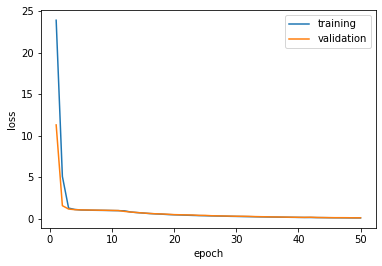

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 학습된 가중치와 편향 확인하기

학습된 모델은 훈련 과정 중 optimizer에 의해 결정된 최종 가중치와 편향으로 구성된다. 네트워크 모델에 따라 각 레이어에 대해 다음 값을 예상해야 합니다.
* 1번 레이어 : 10개의 출력 노드로 가는 4개의 입력 값이 있으므로 10 x 4 가중치와 10개의 바이어스 값이 있어야 합니다.
* 2번 레이어 : 10개의 출력 노드로 가는 10개의 입력 값이 있으므로 10 x 10개의 가중치와 10개의 바이어스 값이 있어야 합니다.
* 3번 레이어 : 3개의 출력 노드로 가는 10개의 입력 값이 있으므로 3 x 10개의 가중치와 3개의 바이어스 값이 있어야 합니다.

In [13]:
for layer in model.layers:
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    print('------------\nWeights:\n',weights,'\nBiases:\n', biases)

------------
Weights:
 [[-0.27236846 -0.3841947   0.03323996  0.08020484 -0.10909867  0.05681432
  -0.19284694  0.84637016  0.35791102 -0.4905011 ]
 [ 0.27471453  0.21265197  0.08151417 -0.17707926 -0.10406601  0.80806166
   0.347896   -0.05435276 -0.6077087  -0.5447268 ]
 [-0.28836262 -0.634329    0.2833844   0.34767175  0.23550075 -0.01211504
   0.14559285 -0.7979028  -0.51647377  0.3296095 ]
 [-0.42851955 -0.24623463 -0.28597662 -0.5230521  -0.43773973  0.36980167
  -0.07648169  0.23635657  0.75255555 -0.4691702 ]] 
Biases:
 [ 0.          0.         -0.01292545  0.          0.          0.20180525
 -0.19173317 -0.26139873 -0.3151644   0.        ]
------------
Weights:
 [[ 0.0607031  -0.30530828  0.39975524  0.3037489   0.15896738  0.03326017
  -0.53190327  0.40915883 -0.03316814 -0.1240823 ]
 [ 0.42301047  0.14984506 -0.54566675  0.3919103  -0.4295466   0.50397205
  -0.31616646  0.17803025 -0.41518384 -0.38429344]
 [ 0.5336163   0.37752342 -0.4694245   0.17206895 -0.04215616  0.52979

## 모델 성능 평가하기

그렇다면, 이 모델은 좋은 것일까요? 검증 데이터에서 보고된 정확도는 상당히 예측이 잘 된 것처럼 보이지만, 일반적으로 가능한 각 클래스의 예측을 좀 더 깊이 파고 비교하는 것이 유용합니다. 분류 모델의 성능을 시각화하는 일반적인 방법은 각 클래스에 대한 올바른 예측과 잘못된 예측의 crosstab을 보여 주는 *혼동 행렬(confusion matrix)* 을 만드는 것입니다.

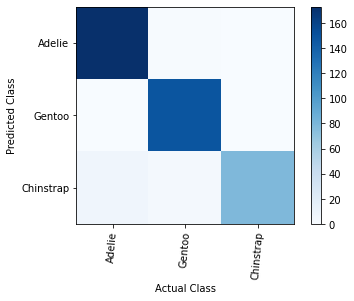

In [14]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=85)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

혼동 행렬은 각 클래스에 대해 부정확한 예측보다 더 많은 정확도가 있음을 강한 대각선 색상으로 표시해서 나타내야 한다.

## 훈련된 모델 저장하기
이제 상당히 정확하다고 생각되는 모델이 생겼으므로 나중에 사용할 수 있도록 교육된 가중치를 저장할 수 있습니다.

In [ ]:
# Save the trained model
modelFileName = 'models/penguin-classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)

## 학습된 모델 사용하기

우리가 새로운 펭귄을 관찰하게 되면, 우리는 학습된 모델을 사용하여 그 펭귄의 종을 예측할 수 있다.

In [ ]:
# Load the saved model
model = models.load_model(modelFileName)

# CReate a new array of features
x_new = np.array([[50.4,15.3,20,50]])
print ('New sample: {}'.format(x_new))

# Use the model to predict the class
class_probabilities = model.predict(x_new)
predictions = np.argmax(class_probabilities, axis=1)

print(penguin_classes[predictions[0]])

## 더 배우기

이 노트는 간단한 Tensorflow 예제를 사용하여 심층 신경망에 대한 기본 개념과 원리를 이해하도록 설계되었습니다. Tensorflow에 대한 자세한 내용은 <a href="https://www.tensorflow.org/" target="_blank">Tensorflow web site</a>를 참조하십시오.